# <p style="text-align: center;"> Charter school identities and outcomes in the accountability era:<br/> Preliminary results
<p style="text-align: center;">April 19th, 2017<br/>By Jaren Haber, PhD Candidate<break/>Dept. of Sociology, UC Berkeley

<p style="text-align: center;">![alt text](http://jaypgreene.files.wordpress.com/2009/12/explosion_600x625600x625.jpg "Old U.S. Map of charter schools by state")
<p style="text-align: center;">(this out-dated graphic courtesy of U.S. News & World Report, 2009)

## Research questions
**How are charter schools different from each other in terms of ideology? How do these differences shape their survival and their outcomes, and what does this reveal about current educational policy?** 

## The corpus
- Website self-descriptions of all **6,753 charter schools** open in 2014-15 (identified using the NCES Public School Universe Survey)
- Charter school websites are a publicly visible proclamation of identity attempting to impress parents, regulators, etc.
- This study the first to use this contemporary, comprehensive data source on U.S. charter school identities
- Me & research team working on using BeautifulSoup and requests.get to webscrape the full sample

### Motivation
- Too much focus on test scores in education, too little on organizational aspects
- Are charter schools innovative? How?
- How does educational policy shape ed. philosophy? Organization? Outcomes?
- No one has studied charters' public image as expressed in their OWN words

### Methods
- NLP: Word frequencies, distinctive words, etc.
- Supervised: Custom dictionaries
- Unsupervised: Topic models, word embeddings
- Later: statistical regression to test, e.g., how progressivist schools in liberal communities have higher performance than they do in other places

## Preliminary analysis: website self-descriptions of non-random sample of 196 schools
- Early-stage sample: NOT representative!
- About half randomly selected, half tracked down (many through Internet Archive) because of missing URLs
- Closed schools over-represented

## Preliminary conclusions: 
### Word counts:
- Website self-descriptions for schools in mid-sized cities and suburbs tend to be longest, followed by other urban and suburban schools, then schools in towns, and shortest tends to be rural schools
- Charter schools in cities and suburbs have the highest textual redundancy (lowest ratio of types to tokens)

### Word embeddings:
- The two educational philosophies I'm interested in--**progressivism** and **essentialism**--can be distinguished using semantic vectors
- Useful way for creating and checking my dictionaries

### Topic modeling:
- Urban charter schools' websites emphasize **GOALS** (topic 0)
- Suburban charter schools' websites emphasize **CURRICULUM** (topic 1) in addition to goals

## Next steps:
- Working with custom dictionaries, POS tagging
- Webscraping and parsing HTML to get full sample
- Match website text with data on test scores and community characteristics (e.g., race, class, political leanings) --> test hypotheses with statistical regression<br/><br/>
- **More long-term**: Collect longitudinal mission statement data from the Internet Archive --> look at survival and geographic dispersion of identity categories over time (especially pre-NCLB if possible)

In [1]:
# The keyword categories to help parse website text:
mission = ['mission',' vision ', 'vision:', 'mission:', 'our purpose', 'our ideals', 'ideals:', 'our cause', 'cause:', 'goals', 'objective']
curriculum = ['curriculum', 'curricular', 'program', 'method', 'pedagogy', 'pedagogical', 'approach', 'model', 'system', 'structure']
philosophy = ['philosophy', 'philosophical', 'beliefs', 'believe', 'principles', 'creed', 'credo', 'value',  'moral']
history = ['history', 'our story', 'the story', 'school story', 'background', 'founding', 'founded', 'established', 'establishment', 'our school began', 'we began', 'doors opened', 'school opened']
general =  ['about us', 'our school', 'who we are', 'overview', 'general information', 'our identity', 'profile', 'highlights']

## Initializing Python

In [2]:
#!/usr/bin/env python
# -*- coding: UTF-8

In [3]:
# IMPORTING KEY PACKAGES
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas # for working with dataframes
import numpy as np # for working with numbers

In [4]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # an approximate method of stemming words (it just cuts off the ends)
from nltk.corpus import stopwords # for one method of eliminating stop words, to clean the text
stopenglish = list(stopwords.words("english")) # assign the string of english stopwords to a variable and turn it into a list
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign the string of common punctuation symbols to a variable and turn it into a list

In [5]:
# FOR ANALYZING WITH THE TEXT
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

import gensim # for word embedding models
from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

In [6]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## Reading in preliminary data

In [8]:
csv.field_size_limit(sys.maxsize)
sample = [] # make empty list
with open('micro-sample_2013.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        sample.append(row) # append each row to the list

# Also read in output.csv, to get newly parsed webtext
new_output = [] # make empty list
with open('output.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        new_output.append(row) # append each row to the list

In [211]:
# sample[0]

In [212]:
# new_output[0]

In [11]:
# First initialize every school's WEBTEXT value
for s in sample:
    s["WEBTEXT"] = ""

# For every school in which we have parsed html, use string matching to find
# the matching school in micro-sample_2013.csv
for output in new_output:
    index = 0
    for s in sample:
        if s["SCHNAM"].lower() == output["SCH_NAME"].lower():
            break
        index += 1
    # If index is 300, then the school name from output.csv was not found in micro-sample_2013.csv
    if index != 300:
        sample[index]["WEBTEXT"] = output["alltext"]

# Write the merged list of ordered dicts to merged.csv
with open('merged.csv', 'w', newline='') as csvfile:
    fieldnames = list(sample[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for s in sample:
        writer.writerow(s)

In [213]:
# Take a look at the most important contents and the variables list
# in our sample (a list of dictionaries)--let's look at just the first entry
# print(sample[1]["SCHNAM"], "\n", sample[1]["URL"], "\n", sample[1]["WEBTEXT"], "\n")
# print(sample[1].keys()) # look at all the variables!

In [13]:
# Read the newly merged data in as a pandas dataframe
df = pandas.read_csv("full_merged.csv", encoding = 'Latin-1')
df = df.dropna(subset=["WEBTEXT"]) # drop any schools with no webtext that might have snuck in (none currently)

In [14]:
# Add additional variables for analysis:
# PCTETH = percentage of enrolled students belonging to a racial minority
# this includes American Indian, Asian, Hispanic, Black, Hawaiian, or Pacific Islander
df["PCTETH"] = (df["AM"] + df["ASIAN"] + df["HISP"] + df["BLACK"] + df["PACIFIC"]) / df["MEMBER"]

df["STR"] = df["MEMBER"] / df["FTE"] # Student/teacher ratio
df["PCTFRPL"] = df["TOTFRL"] / df["MEMBER"] # Percent of students receiving FRPL

# Another interesting variable: 
# TYPE = type of school, where 1 = regular, 2 = special ed, 3 = vocational, 4 = other/alternative, 5 = reportable program

In [15]:
## Print the webtext from the first school in the dataframe
print(df.iloc[2]["WEBTEXT"])

River City Scholars is a free public charter school serving young-five kindergarten through 8th grade. Seats are filling fast, so ! Founded on academic excellence, moral focus, parental partnership, and student responsibility, River City Scholars is a school like no other Ã¢ÂÂone that can lead to a lifetime of success. We provide a safe learning environment and our exceptional teachers individualize instruction based on your childÃ¢ÂÂs needs. In addition, we focus on real-world skills and how to be a good person. Our students also draft a social contract that reinforces their commitment to their school, their teacher, and each other. If you would like to schedule a school tour to learn more about our academic program, Moral Focus curriculum, and school environment, please feel free to contact us for more information. We look forward to hearing from you! Menu Call Map Login Search River City Scholars 944 Evergreen St Grand Rapids , MI 49507 616-248-3390 Fax: 616-723-0128 School Hour

## Descriptive statistics

### How urban proximity is coded: Lower number = more urban (closer to large city) 

More specifically, it uses two digits with distinct meanings: 
- the first digit: 
    - 1 = city
    - 2 = suburb
    - 3 = town
    - 4 = rural
- the second digit:
    - 1 = large or fringe
    - 2 = mid-size or distant
    - 3 = small/remote

In [16]:
# print(df.describe()) # get descriptive statistics for all numerical columns
# print()
# print(df['ULOCAL'].value_counts()) # frequency counts for categorical data
# print()
# print(df['LEVEL'].value_counts()) # treat grade range served as categorical
# # Codes for level/ grade range served: 3 = High school, 2 = Middle school, 1 = Elementary, 4 = Other)
# print()
# print(df['LSTATE'].mode()) # find the most common state represented in these data
# print(df['ULOCAL'].mode()) # find the most urbanicity represented in these data
# print(df['FTE']).mean() # What's the average number of full-time employees by school?
# print(df['STR']).mean() # And the average student-teacher ratio?

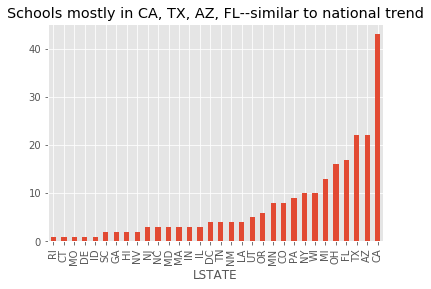

In [20]:
# here's the number of schools from each state, in a graph:
grouped_state = df.groupby('LSTATE')
grouped_state['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Schools mostly in CA, TX, AZ, FL--similar to national trend')
plt.show()

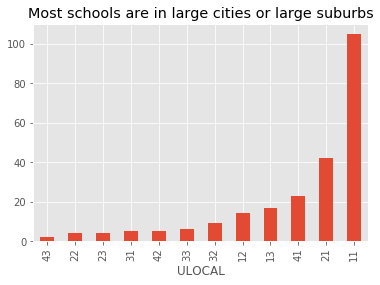

In [21]:
# and here's the number of schools in each urban category, in a graph:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Most schools are in large cities or large suburbs')
plt.show()

#### What these numbers say about the charter schools in the sample:
- Most are located in large cities, followed by large suburbs, then medium and small city, and then rural.
- The means for percent minorities and students receiving free- or reduced-price lunch are both about 60%.
- Most are in CA, TX, AZ, and FL
- Most of the schools in the sample are primary schools

#### This means that the sample reflects national averages. In that sense, this sample isn't so bad.

## Cleaning, tokenizing, and stemming the text

In [22]:
# Now we clean the webtext by rendering each word lower-case then removing punctuation. 
df['webtext_lc'] = df['WEBTEXT'].str.lower() # make the webtext lower case
df['webtokens'] = df['webtext_lc'].apply(nltk.word_tokenize) # tokenize the lower-case webtext by word
df['webtokens_nopunct'] = df['webtokens'].apply(lambda x: [word for word in x if word not in list(string.punctuation)]) # remove punctuation

In [214]:
print(df.iloc[0]["webtokens"][:100]) # the tokenized text without punctuation

['2016', 'richland', 'two', 'career', 'pathways', 'expo', 'richland', 'school', 'district', 'two', 'will', 'be', 'hosting', 'a', 'career', 'pathways', 'expo', 'on', 'thursday', ',', 'october', '27', 'from', '3:00', 'pm', 'to', '7:00', 'pm', 'at', 'the', 'newest', 'facility', ',', 'r2i2', '(', 'behind', 'the', 'village', 'at', 'sandhill', ')', '.', 'all', 'students', 'in', 'grades', '7-12', 'along', 'with', 'their', 'parents/and', 'or', 'guardians', 'are', 'invited', 'to', 'attend', '.', 'students', 'will', 'be', 'able', 'to', 'explore', 'careers', 'and', 'educational', 'opportunities', 'in', '5', 'career', 'areas', '--', 'health', 'science', ',', 'art', ',', 'stem', ',', 'business/it', ',', 'human', 'services/education', '.', 'you', 'will', 'have', 'the', 'opportunity', 'to', 'speak', 'with', 'businesses', 'and', 'educational', 'institutions', 'to', 'see', 'the']


In [24]:
# Now we remove stopwords and stem. This will improve the results
df['webtokens_clean'] = df['webtokens_nopunct'].apply(lambda x: [word for word in x if word not in list(stopenglish)]) # remove stopwords
df['webtokens_stemmed'] = df['webtokens_clean'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

In [25]:
# Some analyses require a string version of the webtext without punctuation or numbers.
# To get this, we join together the cleaned and stemmed tokens created above, and then remove numbers and punctuation:
df['webtext_stemmed'] = df['webtokens_stemmed'].apply(lambda x: ' '.join(char for char in x))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if char not in punctuations))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

In [26]:
df['webtext_stemmed'][0]

' richland two career pathway expo richland school district two host career pathway expo thursday octob   pm  pm newest facil ri behind villag sandhil student grade  along parentsand guardian invit attend student abl explor career educ opportun  career area  health scienc art stem businessit human serviceseduc opportun speak busi educ institut see connect learn high school possibl career question pleas contact mrs holland richland  charter high school move new locat locat anna boyd school  brookmont lane columbia sc  congratul  graduat view video ceremoni view thevideo june   graduat ceremoni charter high school inform monday august   richland two career pathway expo  richland two career pathway expo richland school district two host career pathway expo thursday octob   pm  pm newest facil ri behind villag sandhil student grade  along parentsand guardian invit attend student abl explor career educ opportun  career area  health scienc art stem businessit human serviceseduc opportun spea

In [27]:
# Some analyses require tokenized sentences. I'll do this with the list of dictionaries.
# I'll use cleaned, tokenized sentences (with stopwords) to create both a dictionary variable and a separate list for word2vec

words_by_sentence = [] # initialize the list of tokenized sentences as an empty list
for school in sample:
    school["sent_toksclean"] = []
    school["sent_tokens"] = [word_tokenize(sentence) for sentence in sent_tokenize(school["WEBTEXT"])] 
    for sent in school["sent_tokens"]:
        school["sent_toksclean"].append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)]) # for each word: stem, lower-case, and remove punctuations
        words_by_sentence.append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)])

In [28]:
words_by_sentence[:2]

[['2016',
  'richland',
  'two',
  'career',
  'pathway',
  'expo',
  'richland',
  'school',
  'district',
  'two',
  'will',
  'be',
  'host',
  'a',
  'career',
  'pathway',
  'expo',
  'on',
  'thursday',
  'octob',
  '27',
  'from',
  '3:00',
  'pm',
  'to',
  '7:00',
  'pm',
  'at',
  'the',
  'newest',
  'facil',
  'r2i2',
  'behind',
  'the',
  'villag',
  'at',
  'sandhil'],
 ['all',
  'student',
  'in',
  'grade',
  '7-12',
  'along',
  'with',
  'their',
  'parents/and',
  'or',
  'guardian',
  'are',
  'invit',
  'to',
  'attend']]

### Counting document lengths

In [29]:
# We can also count document lengths. I'll mostly use the version with punctuation removed but including stopwords,
# because stopwords are also part of these schools' public image/ self-presentation to potential parents, regulators, etc.

df['webstem_count'] = df['webtokens_stemmed'].apply(len) # find word count without stopwords or punctuation
df['webpunct_count'] = df['webtokens_nopunct'].apply(len) # find length with stopwords still in there (but no punctuation)
df['webclean_count'] = df['webtokens_clean'].apply(len) # find word count without stopwords or punctuation

In [30]:
# For which urban status are website self-description the longest?
print(grouped_urban['webpunct_count'].mean().sort_values(ascending=False))

ULOCAL
31    498.000000
13    473.470588
41    446.434783
12    420.928571
11    359.819048
21    355.785714
43    325.000000
23    213.750000
32    200.777778
42    171.000000
33    171.000000
22    168.250000
Name: webpunct_count, dtype: float64


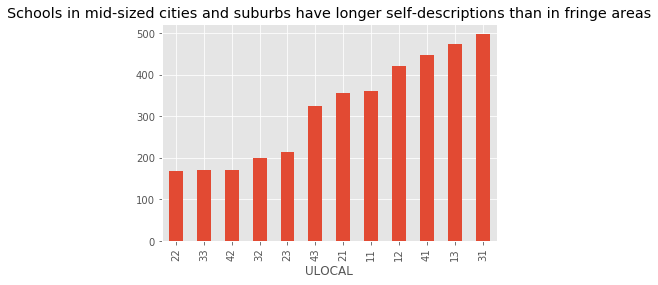

In [31]:
# here's the mean website self-description word count for schools grouped by urban proximity, in a graph:
grouped_urban['webpunct_count'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Schools in mid-sized cities and suburbs have longer self-descriptions than in fringe areas', yerr = grouped_state["webpunct_count"].std())
plt.show()

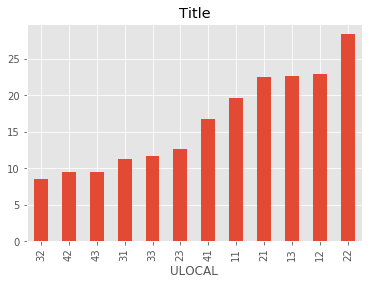

In [32]:
# Look at 'FTE' (proxy for # administrators) clustered by urban proximity and whether it explains this
grouped_urban['FTE'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Title', yerr = grouped_state["FTE"].std())
plt.show()

In [33]:
# Now let's calculate the type-token ratio (TTR) for each school, which compares
# the number of types (unique words used) with the number of words (including repetitions of words).

df['numtypes'] = df['webtokens_nopunct'].apply(lambda x: len(set(x))) # this is the number of unique words per site
df['TTR'] =  df['numtypes'] / df['webpunct_count'] # calculate TTR

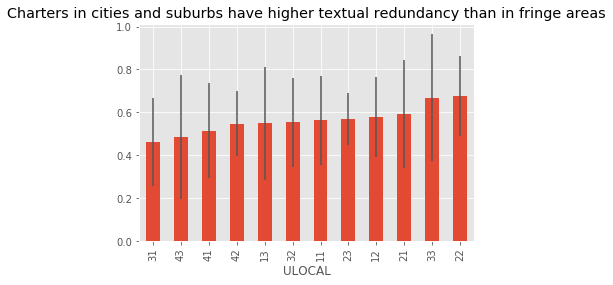

In [34]:
# here's the mean TTR for schools grouped by urban category:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['TTR'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Charters in cities and suburbs have higher textual redundancy than in fringe areas', yerr = grouped_urban["TTR"].std())
plt.show()

## (Excessively) Frequent words

In [35]:
# First, aggregate all the cleaned webtext:
webtext_all = []
df['webtokens_clean'].apply(lambda x: [webtext_all.append(word) for word in x])
webtext_all[:20]

['2016',
 'richland',
 'two',
 'career',
 'pathways',
 'expo',
 'richland',
 'school',
 'district',
 'two',
 'hosting',
 'career',
 'pathways',
 'expo',
 'thursday',
 'october',
 '27',
 '3:00',
 'pm',
 '7:00']

In [36]:
# Now apply the nltk function FreqDist to count the number of times each token occurs.
word_frequency = nltk.FreqDist(webtext_all)

#print out the 50 most frequent words using the function most_common
print(word_frequency.most_common(50))

[('school', 1601), ('students', 820), ('academy', 420), ('2016', 400), ('schools', 345), ('high', 340), ('learning', 329), ('charter', 314), ('september', 263), ('student', 258), ('education', 250), ('community', 239), ('day', 233), ('pm', 219), ('program', 219), ("'s", 218), ('please', 213), ('year', 211), ('sep', 207), ('life', 199), ('grade', 195), ('new', 191), ('»', 191), ('skills', 188), ('campus', 180), ('college', 172), ('public', 166), ('...', 163), ('us', 161), ('ã¢â\x80â\x93', 161), ('elementary', 161), ('ã¯â', 159), ('â¿', 159), ('information', 154), ('academic', 152), ('grades', 149), ('p.m.', 144), ('child', 133), ('parents', 131), ('curriculum', 128), ('teachers', 126), ('welcome', 125), ('middle', 122), ('state', 121), ('parent', 118), ('office', 118), ('free', 117), ('district', 113), ('arts', 111), ('environment', 110)]


 ### These are prolific, ritual, empty words and will be excluded from topic models!

## Distinctive words (mostly place names)

In [221]:
sklearn_dtm = countvec.fit_transform(df['webtext_stemmed'])
# print(sklearn_dtm)

In [38]:
# What are some of the words in the DTM? 
print(countvec.get_feature_names()[:10])

['a', 'aa', 'aaliyah', 'aalt', 'aaron', 'aasc', 'aasd', 'ab', 'abid', 'abil']


In [39]:
# now we can create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pandas.DataFrame(tfidfvec.fit_transform(df.webtext_stemmed).toarray(), columns=tfidfvec.get_feature_names(), index = df.index)

dtm_tfidf_df[:20] # let's take a look!

,aa,aaliyah,aalt,aaron,aasc,aasd,ab,abid,abil,abl,...,zoelearningacademyorg,zone,zoo,zucchini,zulu,zweben,ân,ânistasã,âºn,âºtbol
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.068272,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.058525,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.020747,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [40]:
# What are the 20 words with the highest TF-IDF scores?
print(dtm_tfidf_df.max().sort_values(ascending=False)[:20])

richardallenlacom              1.000000
lawschoolbu                    1.000000
index                          1.000000
isplacedwithsitedesignertru    0.953771
sep                            0.948295
summit                         0.902393
offlin                         0.891054
mater                          0.879109
aa                             0.874038
gestalt                        0.834073
calendar                       0.830806
midwest                        0.828513
close                          0.816707
quick                          0.788615
ncsa                           0.769825
pm                             0.754604
pasadenarosebudcom             0.749104
theeducenterscom               0.749104
ideapublicschoolscom           0.749104
zoelearningacademyorg          0.749104
dtype: float64


### Like the frequent words above, these highly "unique" words are empty of meaning and will be excluded from topic models!

## Word Embeddings with word2vec

### Word2Vec features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
<li>Worker: Set the 'worker' option to ensure reproducibility</li>
</ul>

In [41]:
# train the model, using a minimum of 5 words
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=2, sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

In [42]:
# dictionary of words in model (may not work for old gensim)
# print(len(model.vocab))
# model.vocab

In [43]:
# Find cosine distance between two given word vectors
# print(model.wv.similarity('college-prep','align')) # these two are close to essentialism
# print(model.similarity('emot', 'curios')) # these two are close to progressivism

In [44]:
# create some rough dictionaries for our contrasting educational philosophies
# essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
#                             'market', 'research', 'program', 'standards-bas']
# progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
#                 'ethic', 'independ', 'discov', 'deep', 'natur']

def load_dict(path):
    dictionary = []
    with open(path, "r", encoding="utf-8") as file:
        line = file.readline()
        while line:
            line = line.replace('\x00', '')
            if line[-1] == "\n":
                line = line[:-1]
            if line != "":
                dictionary.append(line)
            line = file.readline()
    return dictionary
    

essentialism = load_dict("custom_dicts/ess_dict.txt")
progressivism = load_dict("custom_dicts/prog_dict.txt")
ritual = load_dict("custom_dicts/rit_dict.txt")
print(essentialism[-10:])
print(progressivism[-10:])
print(ritual[-10:])

['uniform', 'university prep', 'videotaped lessons', 'vocational', 'vulnerable', 'wage earner', 'work-related', 'worker', 'workplace', 'workstation']
['well-being', 'well-rounded', 'wellness', 'whole child', 'whole-child', 'wildlife', 'worker bee', 'worker-bee', 'yarn', 'zest']
['tough', 'track', 'train', 'tutoring', 'unique', 'upgrade', 'value', 'virtual', 'world', 'year']


In [45]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.wv.most_similar('align')) # words core to essentialism
print()
print(model.wv.most_similar('emot')) # words core to progressivism

[('real', 0.9961706399917603), ('both', 0.9959432482719421), ('lead', 0.9958130121231079), ('lab', 0.9955419898033142), ('partnership', 0.9953651428222656), ('counsel', 0.9951192140579224), ('comprehens', 0.9945567846298218), ('inquiry-bas', 0.9941493272781372), ('creation', 0.9938904047012329), ('innov', 0.9938333034515381)]

[('creativ', 0.9990870952606201), ('growth', 0.9979804754257202), ('teach', 0.9969954490661621), ('collabor', 0.9960702657699585), ('knowledg', 0.995128870010376), ('comput', 0.9949371814727783), ('charact', 0.9948013424873352), ('combin', 0.9947836399078369), ('cours', 0.9946851134300232), ('project', 0.994670569896698)]


In [46]:
print(model.wv.most_similar('emot')) # words core to progressivism

[('creativ', 0.9990870952606201), ('growth', 0.9979804754257202), ('teach', 0.9969954490661621), ('collabor', 0.9960702657699585), ('knowledg', 0.995128870010376), ('comput', 0.9949371814727783), ('charact', 0.9948013424873352), ('combin', 0.9947836399078369), ('cours', 0.9946851134300232), ('project', 0.994670569896698)]


In [47]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
filtered_progressivism = list(filter(lambda x: x in model.wv.vocab, progressivism))
prog_words = model.wv.most_similar(filtered_progressivism, topn=50)
prog_words = [word for word, similarity in prog_words]
for word in filtered_progressivism:
    prog_words.append(word)
print(prog_words[:20])

['flourish', 'civic', 'environment', 'strategi', 'intens', 'specialist', 'project-bas', 'after-school', 'pursuit', 'bodi', 'peac', 'dotâ\x80\x99', 'inclus', 'reward', 'ownership', 'engageni', 'strengthen', 'role', 'equal', 'experienti']


In [48]:
filtered_essentialism = list(filter(lambda x: x in model.wv.vocab, essentialism)) # now let's get the 50 most similar words for our essentialist dictionary
ess_words = model.wv.most_similar(filtered_essentialism, topn=50)
ess_words = [word for word, similarity in ess_words]
for word in essentialism:
    ess_words.append(word)
print(ess_words[:20])

['persever', 'got', 'came', 'whose', 'dilig', 'oneâ\x80\x99', 'stimul', 'tailor', 'face', 'fail', 'expand', 'extra', '12.05.2012', 'wear', 'fear', 'technic', 'major', 'perspect', 'friendli', 'money']


In [49]:
filtered_rit = list(filter(lambda x: x in model.wv.vocab, ritual)) # now let's get the 50 most similar words for our dictionary of ritual words
rit_words = model.wv.most_similar(filtered_rit, topn=50)
rit_words = [word for word, similarity in rit_words]
for word in ritual:
    rit_words.append(word)
print(rit_words[:20])

['cultiv', 'incorpor', 'intervent', 'worth', 'trend', 'compass', 'gain', 'accord', 'immun', 'sonora', 'architect', 'reflect', 'principl', 'fulfil', 'deliv', 'high-qual', 'trip', 'around', 'diploma', 'thrive']


In [50]:
# construct an combined dictionary
phil_words = ess_words + prog_words + rit_words
phil_words = list(filter(lambda x: x in model.wv.vocab, phil_words))

In [51]:
# preparing for visualizing this binary with word2vec
x = [model.wv.similarity('emot', word) for word in phil_words]
y = [model.wv.similarity('align', word) for word in phil_words]

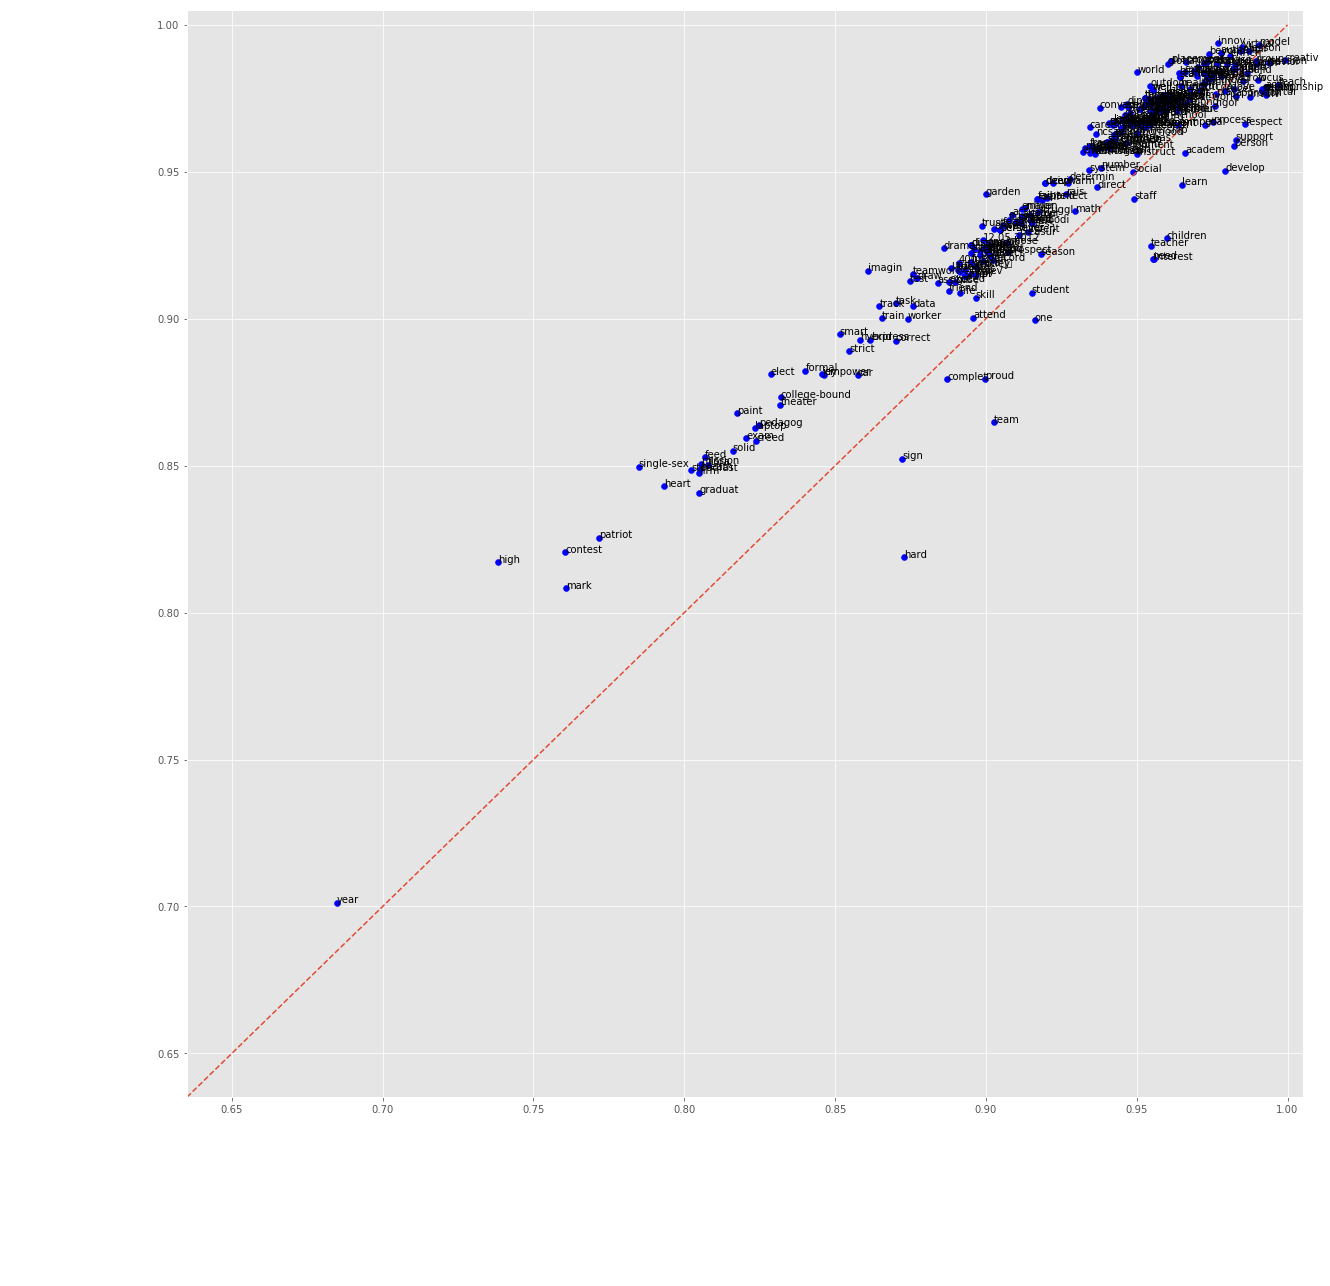

In [52]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(.635, 1.005)
ax.set_ylim(.635, 1.005)
plt.plot([0, 1], [0, 1], linestyle='--');

### Applying Custom Dictionary Analysis to home pages

In [53]:
# Find the number of words associated with each philosophy, and also list the unique words
df['prog_words'] = df['webtokens_clean'].apply(lambda x: np.unique([word for word in x if word in progressivism]))
df['prog_num'] = df['webtokens_clean'].apply(lambda x: len([word for word in x if word in progressivism]))

df['ess_words'] = df['webtokens_clean'].apply(lambda x: np.unique([word for word in x if word in essentialism]))
df['ess_num'] = df['webtokens_clean'].apply(lambda x: len([word for word in x if word in essentialism]))

df['rit_words'] = df['webtokens_clean'].apply(lambda x: np.unique([word for word in x if word in ritual]))
df['rit_num'] = df['webtokens_clean'].apply(lambda x: len([word for word in x if word in ritual]))

df['prog_prop'] = df['prog_num']/df['webclean_count']
df['ess_prop'] = df['ess_num']/df['webclean_count']
df['rit_prop'] = df['rit_num']/df['webclean_count']

df[:5][["LEANM", "prog_words", "ess_words", "rit_words", "prog_num", "ess_num", "rit_num", "prog_prop", "ess_prop", "rit_prop"]]

,LEANM,prog_words,ess_words,rit_words,prog_num,ess_num,rit_num,prog_prop,ess_prop,rit_prop
0,RICHLAND 02,"[health, village]",[career],"[attend, charter, facility, high, information,...",6,15,47,0.015038,0.037594,0.117794
1,POLK,[],[],"[high, provide, school]",0,0,6,0.000000,0.000000,0.072289
2,RIVER CITY SCHOLARS CHARTER ACADEMY,"[feed, social]","[career, office]","[charter, children, environment, exceptional, ...",2,4,34,0.010152,0.020305,0.172589
3,DETROIT ENTERPRISE ACADEMY,"[feed, social]",[career],"[charter, children, environment, exceptional, ...",2,2,35,0.011050,0.011050,0.193370
4,LIGHTHOUSE COMMUNITY SCH INC,"[interest, social]",[],"[behavior, charter, children, community, educa...",3,0,34,0.018519,0.000000,0.209877


In [54]:
print("Average Progressivism score:", np.mean(df["prog_prop"]))
print("Average Essentialism score:",np.mean(df["ess_prop"]))

Average Progressivism score: 0.009693611304210616
Average Essentialism score: 0.013199271012119375


#### Plotting Progressivism vs Essentialism

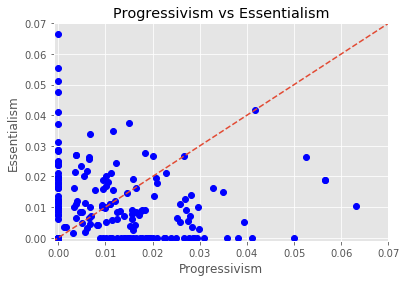

In [55]:
plt.plot(df["prog_prop"], df["ess_prop"], 'bo')
plt.axis([-.001, .07, -0.001, .07])
plt.plot([-1, 1], [-1, 1], linestyle='--')
plt.xlabel('Progressivism')
plt.ylabel('Essentialism')
plt.title("Progressivism vs Essentialism")
plt.show()

In [56]:
for school in df.iterrows():
    if school[1]['ess_prop'] > 0.04 and school[1]['ess_prop'] < 0.045 and school[1]['prog_prop'] == 0:
        print(school[1]["SCHNAM"])
sample[102]["SCHNAM"]

ACADEMIC AND CAREER EDUCATION ACADEMY


'NEVADA CITY SCHOOL OF THE ARTS'

In [57]:
prog_count, ess_count = 0, 0
for school in df.iterrows():
    if school[1]['prog_prop'] > school[1]['ess_prop']:
        prog_count += 1
    elif school[1]['prog_prop'] < school[1]['ess_prop']:
        ess_count += 1
prog_count, ess_count

(84, 80)

#### the first digit:
1 = city, 2 = suburb, 3 = town, 4 = rural

#### the second digit:
1 = large or fringe, 2 = mid-size or distant, 3 = small/remote

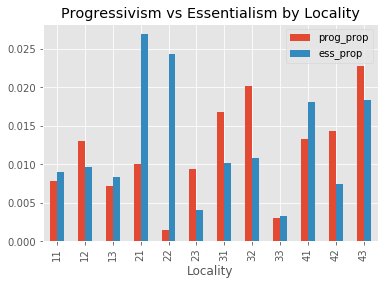

In [58]:
grouped_urban = df.groupby('ULOCAL').mean()
grouped_urban[["prog_prop", "ess_prop"]].plot(kind = 'bar', title='Progressivism vs Essentialism by Locality')
plt.xlabel("Locality")
plt.show()

Grouping the above results by locality and not distinguishing the size:

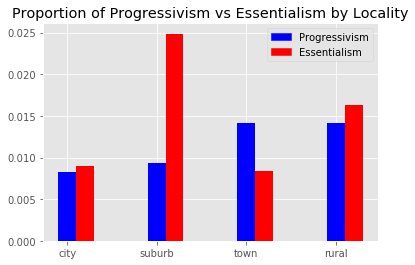

In [59]:
counts = [0, 0, 0, 0]
prog_props = [0, 0, 0, 0]
ess_props = [0, 0, 0, 0]
for school in df.iterrows():
    counts[school[1]["ULOCAL"] // 10 - 1] += 1
    prog_props[school[1]["ULOCAL"] // 10 - 1] += school[1]['prog_prop']
    ess_props[school[1]["ULOCAL"] // 10 - 1] += school[1]['ess_prop']
for i in range(len(counts)):
    prog_props[i] = prog_props[i] / counts[i]
    ess_props[i] = ess_props[i] / counts[i]

x = [0.9, 1.9, 2.9, 3.9]
x2 = [1.1, 2.1, 3.1, 4.1]

ax = plt.subplot(111)
ax.bar(x, prog_props,width=0.2,color='b',align='center')
ax.bar(x2, ess_props,width=0.2,color='r',align='center')
blue_patch = mpatches.Patch(color='blue', label='Progressivism')
red_patch = mpatches.Patch(color='red', label='Essentialism')
plt.legend(handles=[blue_patch, red_patch])
my_xticks = ['city', 'suburb', 'town', 'rural']
plt.xticks(x, my_xticks)
plt.title("Proportion of Progressivism vs Essentialism by Locality")
plt.show()

Just by looking at the above graph, we can see that large to medium sized suburbs heavily favor essentialism.

Towns seem to favor progressivism, while in cities and rural areas the ratios are more balanced.

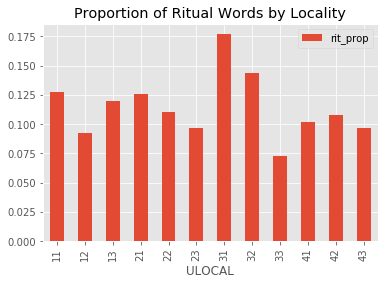

In [60]:
grouped_urban[["rit_prop"]].plot(kind = 'bar', title='Proportion of Ritual Words by Locality')
plt.show()

In [61]:
from scipy.stats.stats import pearsonr

pearson_prog = pearsonr(df["PCTETH"], df["prog_prop"])
peason_ess = pearsonr(df["PCTETH"], df["ess_prop"])
peason_rit = pearsonr(df["PCTETH"], df["rit_prop"])

print("Pearson correlation coefficient for progressivism is:", pearson_prog[0])
print("p-value:", pearson_prog[1])
print()
print("Pearson correlation coefficient for essentialism is:", peason_ess[0])
print("p-value:", peason_ess[1])
print()
print("Pearson correlation coefficient for ritualism is:", peason_rit[0])
print("p-value:", peason_rit[1])
print()

Pearson correlation coefficient for progressivism is: -0.10824503759
p-value: 0.0971277876357

Pearson correlation coefficient for essentialism is: 0.0885390445728
p-value: 0.175225045234

Pearson correlation coefficient for ritualism is: -0.0292184578252
p-value: 0.655182261048



The above results imply that there is a slight positive linear correlation between essentialism and higher percentages of minority students, and a slight negative linear correlation between progressivism and higher percentages of minority students.

Also there appears to be no correlation with usage of ritual words and the percentage of students that are of a minority ethnicity.

## Incorporating Political Party Preferences

Here we'll incorporate political party affiliations.
The 2012_presidential_election_results.csv file contains the voting results for the 2012 presidential election, listed by county.  We'll find the proportion of voters in each county that voted according to each party in order to get an estimate of political leanings for each county.  We can then match the county numbers of each charter school to the voting results.

In [369]:
election_df = pandas.read_csv("2012_presidential_election_results.csv") # read in the election csv

# Get the columns for party names and votes for that party
party_columns = ["Party"] + ["Party." + str(i) for i in range(1, 16)]
votes_columns = ["Votes"] + ["Votes." + str(i) for i in range(1, 16)]

all_parties = set()

# Iterate through all counties
all_party_vote_totals = dict()
for index, row in election_df.iterrows():
    party_vote_totals = dict()
    total_votes = row["TOTAL VOTES CAST"] # number of votes cast in the county
    for i in range(len(party_columns)):
        # Get the first party name.  The order of the parties is based on vote count 
        # and changes county to county
        if not pandas.isnull(row[party_columns[i]]):
            party, vote_count = row[party_columns[i]], row[votes_columns[i]] # get party name and votes received
            all_parties.add(party)
            # Combine vote totals for the party in the county.
            if party in party_vote_totals:
                # This is when there are multiple candidates running from the same party (typically independents)
                party_vote_totals[party] += vote_count
            else:
                party_vote_totals[party] = vote_count
    # Normalize vote counts to get proportions of votes rather than vote counts
    for party in party_vote_totals:
        if total_votes > 0:
            party_vote_totals[party] = round(party_vote_totals[party] / total_votes, 5)
    all_party_vote_totals[row["FIPS Code"]] = party_vote_totals

/Users/bradafzali/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (44,108,109,111,120,121,123,132,133,135,144,145,147,156,157,159,168,169,171,180,181,183,192,193,195) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [370]:
all_parties # list of all parties found in the election results, for reference

{'AIP',
 'ATP',
 'AmC',
 'AmP',
 'CST',
 'Cnl',
 'DCG',
 'Dem',
 'GOP',
 'GRP',
 'Grn',
 'IAP',
 'IP',
 'Ind',
 'JP',
 'Lib',
 'Mnt',
 'NLP',
 'NMI',
 'NPA',
 'NPD',
 'Obj',
 'PAG',
 'PEC',
 'PFP',
 'PSL',
 'Prg',
 'Pro',
 'RP',
 'SEP',
 'SPU',
 'SWP',
 'Soc',
 'UST',
 'Una',
 'WTP'}

Match each charter school's listed county number with its voting results and store it in a "Vote Totals" column

In [371]:
df_vote_totals = []
for index, row in df.iterrows():
    if row["CONUM"] not in all_party_vote_totals:
        print("County " + str(row["CONUM"]) + " not found in election results")
    else:
        df_vote_totals.append(all_party_vote_totals[row["CONUM"]])
df["Vote Totals"] = df_vote_totals
df[["SCHNAM", "Vote Totals"]][:10]

,SCHNAM,Vote Totals
0,RICHLAND TWO CHARTER HIGH,"{'GOP': 0.32671, 'Lib': 0.00649, 'Dem': 0.6597..."
1,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL,"{'GOP': 0.5291, 'Dem': 0.46091, 'Obj': 0.0006,..."
2,RIVER CITY SCHOLARS CHARTER ACADEMY,"{'Dem': 0.45549, 'GOP': 0.53416, 'UST': 0.0057..."
3,DETROIT ENTERPRISE ACADEMY,"{'Dem': 0.73117, 'GOP': 0.26236, 'UST': 0.0022..."
4,LIGHTHOUSE COMMUNITY SCH INC,"{'Dem': 0.51794, 'GOP': 0.46862, 'Soc': 0.0002..."
5,WESTLAKE CHARTER MIDDLE,"{'Dem': 0.56962, 'GOP': 0.40632, 'PFP': 0.0045..."
6,VAN GOGH CHARTER,"{'Dem': 0.68874, 'GOP': 0.28815, 'PFP': 0.0043..."
7,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,"{'Dem': 0.50728, 'GOP': 0.47662, 'Soc': 0.0006..."
8,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES,"{'Dem': 0.49385, 'GOP': 0.49336, 'Lib': 0.0093..."
9,CITY ACADEMY,"{'Dem': 0.66576, 'GOP': 0.31247, 'JP': 0.00085..."


Here we'll use Partisan Voting Index scores instead of voting records to assess political preference
PVI scores are based on congressional district, but the data we have does not say which congressional district a school belongs to.  So, we will use zip codes to map schools to their congressional districts.

In [372]:
def strip_leading_zero(s):
    if s[0] == "0" and len(s) > 1:
        return s[1:]
    return s

# Get mapping from zip code to congressional district
zip_dict = dict()
with open("natl_zccd_delim.txt") as f:
    line = f.readline().replace("\n", "")
    while line:
        line = line.split(",")
        line = [strip_leading_zero(el) for el in line]
        zip_dict[line[1]] = line[0] + "," + line[2]
        line = f.readline().replace("\n", "")

# Get mapping from congressional district to PVI score
# Note that negative scores indicate more Democratic and positive scores indicate more Republican
pvi_dict = dict()
with open("pvi_by_county.txt") as f:
    line = f.readline().replace("\n", "")
    while line:
        line = line.split()
        line = [strip_leading_zero(el) for el in line]
        pvi_dict[line[0] + "," + line[1]] = line[2]
        line = f.readline().replace("\n", "")

In [381]:
# Get Berkeley's PVI score
pvi_dict[zip_dict['94709']]

'-37'

In [382]:
# Map schools to their PVI scores and store in a "PVI" column
pvis, not_found, = [], 0
for index, row in df.iterrows():
    if str(row["LZIP"]) not in zip_dict:
        pvis.append(0) # For now defaulting to 0 when zip code not found
        not_found += 1
    else:
        pvi_value = pvi_dict[zip_dict[str(row["LZIP"])]]
        pvis.append(int(pvi_value))
print(str(not_found) + " zip codes not found")
df["PVI"] = pvis
df[["SCHNAM", "PVI"]][:10]

7 zip codes not found


,SCHNAM,PVI
0,RICHLAND TWO CHARTER HIGH,-21
1,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL,-8
2,RIVER CITY SCHOLARS CHARTER ACADEMY,4
3,DETROIT ENTERPRISE ACADEMY,-29
4,LIGHTHOUSE COMMUNITY SCH INC,8
5,WESTLAKE CHARTER MIDDLE,-18
6,VAN GOGH CHARTER,-14
7,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,3
8,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES,13
9,CITY ACADEMY,-11


In [383]:
print(pearsonr(df["PCTETH"], df["PVI"]))
print(pearsonr(df["ess_prop"], df["PVI"]))
print(pearsonr(df["prog_prop"], df["PVI"]))

(-0.37745685244800337, 2.0869066792965026e-09)
(-0.024488783098176158, 0.70820904038783816)
(0.046894004630728806, 0.4733932788622468)


A quick look through Pearson correlation coefficients shows that Republicanism is negatively correlated with higher percentages of minority students.
But correlations between essentialism and progressivism with PVI scores yield no conclusion

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors

## Topic Modeling with scikit-learn
> For documentation on this topic modeling (TM) package, which uses Latent Dirichlet Allocation (LDA), see [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

> And for documentation on the vectorizer package, CountVectorizer from scikit-learn, see [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [223]:
####Adopted From: 
#Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

# Initialize the variables needed for the topic models
n_samples = 2000
n_topics = 5
n_top_words = 50

# Create helper function that prints out the top words for each topic in a pretty way
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [224]:
# Vectorize our text using CountVectorizer
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=70, min_df=4,
                                max_features=None,
                                stop_words=stopenglish, lowercase=1
                                )

tf = tf_vectorizer.fit_transform(df.WEBTEXT)

Extracting tf features for LDA...


In [225]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

# define the lda function, with desired options
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                total_samples=n_samples,
                                random_state=0)
#fit the model
lda.fit(tf)

Fitting LDA models with tf features, n_samples=2000 and n_topics=5...


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=80.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_jobs=1, n_topics=5, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=2000, verbose=0)

In [226]:
# print the top words per topic, using the function defined above.

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #0:
sep date 10 00 math day grade september session elementary program 30 location 15 campus 20 district years time 16 one teachers 35 30pm lunch 8th 11 box 22 teacher first 14 www following parent child guidelines night back end language 13 00pm click courses well meet monday earn friday

Topic #1:
arts program environment learn believe teachers district child academic work programs curriculum campus 00pm every based art staff values middle make self grade classroom best traditional parents state events positive opportunities elementary performing safe st life one develop virtual list social educational fax family experience grades back expectations activities instruction

Topic #2:
pm 30 september 00 life skills college grade information campus grades program elementary free 2015 parent parents 15 academic kipp science state mission posted middle phone office day one welcome prep leadership teacher 11 14 curriculum center thursday child road 2017 fax may 

These topics seem to mean:
- topic 0 relates to **GOALS**,
- topic 1 relates to **CURRICULUM**, and 
- topic 2 relates to **PHILOSOPHY** or learning process (but this topic less clear/ more mottled)

In [227]:
# Preparation for looking at distribution of topics over schools
topic_dist = lda.transform(tf) # transpose topic distribution
topic_dist_df = pandas.DataFrame(topic_dist) # turn into a df
df_w_topics = topic_dist_df.join(df) # merge with charter MS dataframe
df_w_topics[:10] # check out the merged df with topics!

,0,1,2,3,4,LEANM,SEARCH,CER_NAME,URL,ADDRESS,...,prog_words,prog_num,ess_words,ess_num,rit_words,rit_num,prog_prop,ess_prop,rit_prop,Vote Totals
0,0.000850,0.000847,0.996615,0.000842,0.000847,RICHLAND 02,"RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, ...",Richland Two Charter High School,https://www.richland2.org/charterhigh/,"750 OLD CLEMSON RD, COLUMBIA, SC",...,"[health, village]",6.0,[career],15.0,"[attend, charter, facility, high, information,...",47.0,0.015038,0.037594,0.117794,"{'GOP': 0.32671, 'Lib': 0.00649, 'Dem': 0.6597..."
1,0.002895,0.002865,0.561826,0.002847,0.429567,POLK,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 3425...,Charter High Schools | Polk State College,https://www.polk.edu/lakeland-gateway-to-colle...,"3425 WINTER LK RD LAC1200, WINTER HAVEN, FL",...,[],0.0,[],0.0,"[high, provide, school]",6.0,0.000000,0.000000,0.072289,"{'GOP': 0.5291, 'Dem': 0.46091, 'Obj': 0.0006,..."
2,0.001376,0.401073,0.435401,0.098567,0.063583,RIVER CITY SCHOLARS CHARTER ACADEMY,RIVER CITY SCHOLARS CHARTER ACADEMY 944 EVERGR...,River City Scholars Charter Academy,https://www.nhaschools.com/schools/rivercity/P...,"944 EVERGREEN ST, GRAND RAPIDS, MI",...,"[feed, social]",2.0,"[career, office]",4.0,"[charter, children, environment, exceptional, ...",34.0,0.010152,0.020305,0.172589,"{'Dem': 0.45549, 'GOP': 0.53416, 'UST': 0.0057..."
3,0.001682,0.485887,0.343198,0.031211,0.138023,DETROIT ENTERPRISE ACADEMY,"DETROIT ENTERPRISE ACADEMY 11224 KERCHEVAL ST,...",Detroit Enterprise Academy,https://www.nhaschools.com/schools/detroitente...,"11224 KERCHEVAL ST, DETROIT, MI",...,"[feed, social]",2.0,[career],2.0,"[charter, children, environment, exceptional, ...",35.0,0.011050,0.011050,0.193370,"{'Dem': 0.73117, 'GOP': 0.26236, 'UST': 0.0022..."
4,0.001962,0.859605,0.103231,0.033202,0.002000,LIGHTHOUSE COMMUNITY SCH INC,"LIGHTHOUSE COMMUNITY SCH INC 6100 DESMOND ST, ...",Lighthouse Community SchoolÂ¾,https://www.lys.org/services/lighthouse-commun...,"6100 DESMOND ST, CINCINNATI, OH",...,"[interest, social]",3.0,[],0.0,"[behavior, charter, children, community, educa...",34.0,0.018519,0.000000,0.209877,"{'Dem': 0.51794, 'GOP': 0.46862, 'Soc': 0.0002..."
5,0.001252,0.001241,0.995001,0.001246,0.001260,NATOMAS UNIFIED,"WESTLAKE CHARTER MIDDLE 1985 PEBBLEWOOD DR, SA...",Westlake Charter Middle,https://westlakecharter.com,"1985 PEBBLEWOOD DR, SACRAMENTO, CA",...,"[gifted, talented]",2.0,[technology],1.0,"[charter, middle, one, provide, school, story,...",17.0,0.008130,0.004065,0.069106,"{'Dem': 0.56962, 'GOP': 0.40632, 'PFP': 0.0045..."
6,0.000143,0.000142,0.000142,0.000141,0.999432,LOS ANGELES UNIFIED,"VAN GOGH CHARTER 17160 VAN GOGH ST, GRANADA HI...",Van Gogh Charter School,https://vangoghcs-lausd-ca.schoolloop.com/,"17160 VAN GOGH ST, GRANADA HILLS, CA",...,"[animal, festival, trust]",8.0,"[computer, office, respect]",14.0,"[challenge, character, charter, community, edu...",103.0,0.003721,0.006512,0.047907,"{'Dem': 0.68874, 'GOP': 0.28815, 'PFP': 0.0043..."
7,0.001569,0.001583,0.424154,0.571135,0.001559,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON 1...,Summit Academy of Dayton,https://summitacademies.org/schools/dayton-high/,"1407 EAST 3RD ST, DAYTON, OH",...,"[drama, health, music, social, team]",7.0,"[career, office]",3.0,"[approach, children, community, education, hig...",22.0,0.034826,0.014925,0.109453,"{'Dem': 0.50728, 'GOP': 0.47662, 'Soc': 0.0006..."
8,0.011387,0.011299,0.839899,0.011390,0.126026,SPRING BRANCH ISD,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES ...,Westchester Academy of International Studies,https://cms.springbranchisd.com/wais/,"901 YORKCHESTER, HOUSTON, TX",...,[],0.0,[],0.0,[information],1.0,0.000000,0.000000,0.033333,"{'Dem': 0.49385, 'GOP': 0.49336, 'Lib': 0.0093..."
9,0.194612,0.003137,0.796042,0.003078,0.003132,CITY ACADEMY,"CITY ACADEMY 958 JESSIE ST, SAINT PAUL, MN",City Academy,https://cityacademy.org/,"958 JESSIE ST, SAINT PAUL, MN",...,[],0.0,[disability],1.0,"[attend

In [228]:
topic_columns = range(0,n_topics) # Set numerical range of topic columns for use in analyses, using n_topics from above

In [229]:
# Which schools are weighted highest for topic 0? How do they trend with regard to urban proximity and student class? 
print(df_w_topics[['LSTATE', 'ULOCAL', 'PCTETH', 'PCTFRPL', 0, 1, 2]].sort_values(by=[0], ascending=False)[:10])

    LSTATE  ULOCAL    PCTETH   PCTFRPL         0         1         2
75      MI    31.0  0.186047  0.643411  0.999094  0.000227  0.000227
203     MI    21.0  0.998982  0.939919  0.998711  0.000322  0.000323
17      PA    11.0  0.998494  0.936747  0.995336  0.001162  0.001175
149    NaN     NaN       NaN       NaN  0.992896  0.001757  0.001765
88      AZ    41.0  0.341346  0.552885  0.991753  0.002058  0.002067
178     CA    32.0  5.000000  1.000000  0.989939  0.002506  0.002542
138     CA    11.0  0.995157  0.815981  0.988274  0.002933  0.002968
90      CA    21.0  0.846154  0.538462  0.986905  0.003272  0.003284
173    NaN     NaN       NaN       NaN  0.984760  0.003775  0.003804
21      CO    13.0  0.395722  0.368984  0.983249  0.004170  0.004191


In [230]:
# Preparation for comparing total number of words aligned with each topic
# To weight each topic by its prevalenced in the corpus, multiply each topic by the word count from above

col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['webpunct_count']
    
df_w_topics[:10]

,0,1,2,3,4,LEANM,SEARCH,CER_NAME,URL,ADDRESS,...,rit_num,prog_prop,ess_prop,rit_prop,Vote Totals,0_wc,1_wc,2_wc,3_wc,4_wc
0,0.000850,0.000847,0.996615,0.000842,0.000847,RICHLAND 02,"RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, ...",Richland Two Charter High School,https://www.richland2.org/charterhigh/,"750 OLD CLEMSON RD, COLUMBIA, SC",...,47.0,0.015038,0.037594,0.117794,"{'GOP': 0.32671, 'Lib': 0.00649, 'Dem': 0.6597...",0.508076,0.506226,595.975955,0.503342,0.506401
1,0.002895,0.002865,0.561826,0.002847,0.429567,POLK,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 3425...,Charter High Schools | Polk State College,https://www.polk.edu/lakeland-gateway-to-colle...,"3425 WINTER LK RD LAC1200, WINTER HAVEN, FL",...,6.0,0.000000,0.000000,0.072289,"{'GOP': 0.5291, 'Dem': 0.46091, 'Obj': 0.0006,...",0.347442,0.343767,67.419102,0.341599,51.548091
2,0.001376,0.401073,0.435401,0.098567,0.063583,RIVER CITY SCHOLARS CHARTER ACADEMY,RIVER CITY SCHOLARS CHARTER ACADEMY 944 EVERGR...,River City Scholars Charter Academy,https://www.nhaschools.com/schools/rivercity/P...,"944 EVERGREEN ST, GRAND RAPIDS, MI",...,34.0,0.010152,0.020305,0.172589,"{'Dem': 0.45549, 'GOP': 0.53416, 'UST': 0.0057...",0.385279,112.300494,121.912307,27.598629,17.803291
3,0.001682,0.485887,0.343198,0.031211,0.138023,DETROIT ENTERPRISE ACADEMY,"DETROIT ENTERPRISE ACADEMY 11224 KERCHEVAL ST,...",Detroit Enterprise Academy,https://www.nhaschools.com/schools/detroitente...,"11224 KERCHEVAL ST, DETROIT, MI",...,35.0,0.011050,0.011050,0.193370,"{'Dem': 0.73117, 'GOP': 0.26236, 'UST': 0.0022...",0.440632,127.302298,89.917860,8.177208,36.162002
4,0.001962,0.859605,0.103231,0.033202,0.002000,LIGHTHOUSE COMMUNITY SCH INC,"LIGHTHOUSE COMMUNITY SCH INC 6100 DESMOND ST, ...",Lighthouse Community SchoolÂ¾,https://www.lys.org/services/lighthouse-commun...,"6100 DESMOND ST, CINCINNATI, OH",...,34.0,0.018519,0.000000,0.209877,"{'Dem': 0.51794, 'GOP': 0.46862, 'Soc': 0.0002...",0.453172,198.568649,23.846456,7.669768,0.461956
5,0.001252,0.001241,0.995001,0.001246,0.001260,NATOMAS UNIFIED,"WESTLAKE CHARTER MIDDLE 1985 PEBBLEWOOD DR, SA...",Westlake Charter Middle,https://westlakecharter.com,"1985 PEBBLEWOOD DR, SACRAMENTO, CA",...,17.0,0.008130,0.004065,0.069106,"{'Dem': 0.56962, 'GOP': 0.40632, 'PFP': 0.0045...",0.354281,0.351229,281.585261,0.352543,0.356685
6,0.000143,0.000142,0.000142,0.000141,0.999432,LOS ANGELES UNIFIED,"VAN GOGH CHARTER 17160 VAN GOGH ST, GRANADA HI...",Van Gogh Charter School,https://vangoghcs-lausd-ca.schoolloop.com/,"17160 VAN GOGH ST, GRANADA HILLS, CA",...,103.0,0.003721,0.006512,0.047907,"{'Dem': 0.68874, 'GOP': 0.28815, 'PFP': 0.0043...",0.389394,0.386573,0.388728,0.385971,2728.449333
7,0.001569,0.001583,0.424154,0.571135,0.001559,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON 1...,Summit Academy of Dayton,https://summitacademies.org/schools/dayton-high/,"1407 EAST 3RD ST, DAYTON, OH",...,22.0,0.034826,0.014925,0.109453,"{'Dem': 0.50728, 'GOP': 0.47662, 'Soc': 0.0006...",0.411135,0.414762,111.128419,149.637252,0.408432
8,0.011387,0.011299,0.839899,0.011390,0.126026,SPRING BRANCH ISD,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES ...,Westchester Academy of International Studies,https://cms.springbranchisd.com/wais/,"901 YORKCHESTER, HOUSTON, TX",...,1.0,0.000000,0.000000,0.033333,"{'Dem': 0.49385, 'GOP': 0.49336, 'Lib': 0.0093...",0.398539,0.395464,29.396454,0.398634,4.410909
9,0.194612,0.003137,0.796042,0.003078,0.003132,CITY ACADEMY,"CITY ACADEMY 958 JESSIE ST, SAINT PAUL, MN",City Academy,https://cityacademy.org/,"958 JESSIE ST, SAINT PAUL, MN",...,13.0,0.000000,0.010101,0.131313,"{'Dem': 0.66576, 'GOP': 0.31247, 'JP': 0.00085...",30.554098,0.492496,124.978546,0.483205,0.491654


In [232]:
# Now we can see the prevalence of each topic over words for each urban category and state
grouped_urban = df_w_topics.groupby('ULOCAL')
for e in col_list:
    print(e)
    print(grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum())

grouped_state = df_w_topics.groupby('LSTATE')
for e in col_list:
    print(e)
    print(grouped_state[e].sum()/grouped_state['webpunct_count'].sum())

0_wc
ULOCAL
11.0    0.157053
12.0    0.037737
13.0    0.096351
21.0    0.121774
22.0    0.054473
23.0    0.003648
31.0    0.188816
32.0    0.442853
33.0    0.153499
41.0    0.305002
42.0    0.009587
43.0    0.001497
dtype: float64
1_wc
ULOCAL
11.0    0.212132
12.0    0.241074
13.0    0.127149
21.0    0.059722
22.0    0.001971
23.0    0.459157
31.0    0.003394
32.0    0.081059
33.0    0.477156
41.0    0.167422
42.0    0.625315
43.0    0.001500
dtype: float64
2_wc
ULOCAL
11.0    0.461774
12.0    0.544336
13.0    0.691078
21.0    0.720434
22.0    0.877556
23.0    0.468613
31.0    0.800902
32.0    0.236131
33.0    0.056089
41.0    0.493382
42.0    0.197503
43.0    0.825500
dtype: float64
3_wc
ULOCAL
11.0    0.023378
12.0    0.155244
13.0    0.032898
21.0    0.010452
22.0    0.001953
23.0    0.003630
31.0    0.003409
32.0    0.027783
33.0    0.011159
41.0    0.002214
42.0    0.157873
43.0    0.001489
dtype: float64
4_wc
ULOCAL
11.0    0.145663
12.0    0.021609
13.0    0.052525
21.0    0.087

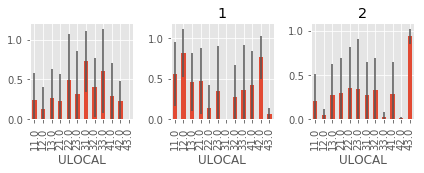

In [250]:
# Here's the distribution of urban proximity over the three topics:
fig1 = plt.figure()
chrt = 0
for num in topic_columns:
    chrt += 1 
    ax = fig1.add_subplot(2,3, chrt)
    grouped_urban[num].mean().plot(kind = 'bar', yerr = grouped_urban[num].std(), ylim=0, ax=ax, title=num)

fig1.tight_layout()
plt.show()

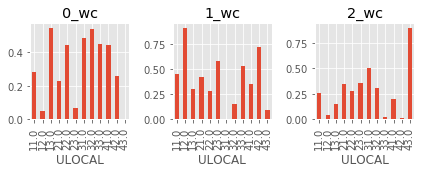

In [251]:
# Here's the distribution of each topic over words, for each urban category:
fig2 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig2.add_subplot(2,3, chrt)
    (grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum()).plot(kind = 'bar', ylim=0, ax=ax2, title=e)

fig2.tight_layout()
plt.show()